In [1]:
import gxgp
from gxgp import DagGP, Node
import operator
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import re
import random
import copy

In [2]:
# -------------------------------
# Define custom mathematical functions
# -------------------------------
def custom_sin(x):
    """Sine function that handles numpy arrays."""
    return np.sin(x)

def custom_cos(x):
    """Cosine function that handles numpy arrays."""
    return np.cos(x)

def custom_exp(x):
    """Exponential function that handles numpy arrays safely."""
    # Clip x to prevent overflow
    clipped_x = np.clip(x, -100, 100)
    return np.exp(clipped_x)

def safe_div(x, y):
    """Division function that prevents division by zero."""
    return x / (y + 1e-6)  # Add small epsilon to avoid division by zero

def square(x):
    """Square function."""
    return x ** 2

def safe_exp(x):
    """Exponential function that prevents overflow."""
    # Clip x to a reasonable maximum value
    clipped_x = np.clip(x, -100, 100)  # Adjust these bounds as needed
    return np.exp(clipped_x)

def safe_log(x):
    """Protected logarithm: returns log(abs(x)+epsilon) to avoid log(0)."""
    return np.log(np.abs(x) + 1e-6)

def safe_sqrt(x):
    """Protected square root: returns sqrt(abs(x)) so the argument is non-negative."""
    return np.sqrt(np.abs(x))

def custom_tanh(x):
    """Hyperbolic tangent function that handles numpy arrays."""
    return np.tanh(x)

def safe_pow(x, y):
    """Protected power function: returns abs(x) raised to the power y safely.
       This version clips the base and avoids division by zero issues."""
    epsilon = 1e-6
    # Take the absolute value and replace near-zero values with epsilon
    base = np.abs(x)
    base = np.where(base < epsilon, epsilon, base)
    # Clip the base to avoid extremely large numbers that cause overflow.
    base = np.clip(base, 0, 100)
    return np.power(base, y)

def cube(x):
    """Cube function."""
    return x ** 3

def reciprocal(x):
    """Reciprocal function with protection against division by zero."""
    return 1.0 / (x + 1e-6)

def sigmoid(x):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-x))

def gaussian(x):
    """Gaussian function."""
    return np.exp(-x ** 2)



In [3]:
def relu(x):
    """Rectified Linear Unit function."""
    return np.maximum(0, x)

def leaky_relu(x):
    """Leaky ReLU function with fixed alpha=0.01."""
    alpha = 0.01
    return np.where(x > 0, x, alpha * x)

def elu(x):
    """Exponential Linear Unit function with fixed alpha=1.0."""
    alpha = 1.0
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def swish(x):
    """Swish activation function."""
    return x * sigmoid(x)

def mish(x):
    """Mish activation function."""
    return x * np.tanh(np.log1p(np.exp(x)))


def sin1_over_x(x):
    """Sine of 1/x function with protection against division by zero."""
    return np.sin(1.0 / (x + 1e-6))

def sinc(x):
    """Sinc function."""
    return np.sinc(x / np.pi)

def sawtooth(x):
    """Sawtooth wave function."""
    return 2 * (x / (2 * np.pi) - np.floor(0.5 + x / (2 * np.pi)))

def triangle_wave(x):
    """Triangle wave function."""
    return 2 * np.abs(2 * (x / (2 * np.pi) - np.floor(x / (2 * np.pi) + 0.5))) - 1

def square_wave(x):
    """Square wave function."""
    return np.sign(np.sin(x))


def bent_identity(x):
    """Bent identity function."""
    return (np.sqrt(x ** 2 + 1) - 1) / 2 + x

def softsign(x):
    """Softsign function."""
    return x / (1 + np.abs(x))

def hard_sigmoid(x):
    """Hard sigmoid function."""
    return np.clip((x + 1) / 2, 0, 1)

def logit(x):
    """Logit function with protection against division by zero."""
    x = np.clip(x, 1e-6, 1 - 1e-6)
    return np.log(x / (1 - x))


def mod(x, y):
    """Modulo operation with protection against division by zero."""
    return np.mod(x, y + 1e-6)

def max_op(x, y):
    """Maximum of two values."""
    return np.maximum(x, y)

def min_op(x, y):
    """Minimum of two values."""
    return np.minimum(x, y)

def average(x, y):
    """Average of two values."""
    return (x + y) / 2

In [4]:
# -------------------------------
# Load problem data
# -------------------------------
selected_problem = 2
data = np.load(f'../data/problem_{selected_problem}.npz')
x_data = data['x']
y_data = data['y']

MAX_SAMPLES = 1000000000
if y_data.shape[0] > MAX_SAMPLES:
    step = y_data.shape[0] // MAX_SAMPLES
    y_true = y_data[::step][:MAX_SAMPLES]
    x_data = x_data[:, ::step][:, :MAX_SAMPLES]
else:
    y_true = y_data

# Transpose x_data so that each row is one sample and each column is one variable.
x_data = x_data.T  # Now x_data.shape becomes (num_samples, num_variables)


In [ ]:
# -------------------------------
# Set up operators and GP parameters
# -------------------------------
# Use one consistent set of operators
operators = [
    operator.add,       # binary: +
    operator.sub,       # binary: -
    operator.mul,       # binary: *
    safe_div,           # binary: protected division
    square,             # unary: square
    cube,               # unary: cube
    custom_sin,         # unary: sine
    custom_cos,         # unary: cosine
    custom_exp,         # unary: exponential (with clipping)
    safe_log,           # unary: protected logarithm
    safe_sqrt,          # unary: protected square root
    custom_tanh,        # unary: tanh
    safe_pow,           # binary: protected power
    reciprocal,         # unary: reciprocal
    sigmoid,            # unary: sigmoid
    gaussian,           # unary: gaussian
    
    relu,               # unary: ReLU
    leaky_relu,         # unary: leaky ReLU
    elu,                # unary: ELU
    swish,              # unary: swish
    mish,               # unary: mish
    sin1_over_x,        # unary: sin(1/x)
    sinc,               # unary: sinc
    sawtooth,           # unary: sawtooth wave
    triangle_wave,      # unary: triangle wave
    square_wave,        # unary: square wave
    bent_identity,      # unary: bent identity
    softsign,           # unary: softsign
    hard_sigmoid,       # unary: hard sigmoid
    logit,              # unary: logit
    mod,                # binary: modulo
    max_op,             # binary: max
    min_op,             # binary: min
    average             # binary: average
]





# Adjusted parameter settings to allow for more growth and complexity
POP_SIZE = 4000          
NUM_GENS = 500         
OFFSPRING_NUM = 1200      
INITIAL_SIZE_MIN = 1    # Minimum size for initial trees
INITIAL_SIZE_MAX = 15   # Maximum size for initial trees 
TOURN_SIZE = 9        
LENGTH_PENALTY = 0
CROSSOVER_PROB = 0.7    
MUTATION_PROB = 0.3     
MAX_TREE_DEPTH = 15     # Maximum depth for any tree to prevent bloat
ADAPTIVE_PENALTY = True # Enable adaptive complexity penalty
MIN_SEMANTIC_THRESHOLD = 0.01 





# -------------------------------
# Initialize the GP system with consistent operators
# -------------------------------
# Note: Ensure that 'operators' is defined in your context.



gp = DagGP(
    operators=operators,
    variables=x_data.shape[1],
    constants=np.linspace(-5, 5, 2000)
)







In [6]:
# -------------------------------
# Tree Structure Functions
# -------------------------------
def get_operator_arity(op):
    """Determine the arity of an operator based on its function signature."""
    import inspect
    
    # Handle built-in operators
    if op in [operator.add, operator.sub, operator.mul]:
        return 2
    
    # For custom functions, check the number of parameters
    try:
        sig = inspect.signature(op)
        params = [p for p in sig.parameters.values() 
                 if p.default == p.empty and p.name not in ['alpha']]  # Exclude optional params
        return len(params)
    except:
        # If inspection fails, assume unary
        return 1

# Create dictionaries for quick lookup
unary_operators = [
    square, cube, custom_sin, custom_cos, custom_exp, safe_log, safe_sqrt,
    """custom_tanh, reciprocal, sigmoid, gaussian, relu, leaky_relu, elu,
    swish, mish, sin1_over_x, sinc, sawtooth, triangle_wave, square_wave,
    bent_identity, softsign, hard_sigmoid, logit"""
]

binary_operators = [
    operator.add, operator.sub, operator.mul, safe_div, safe_pow,
    """mod, max_op, min_op, average"""
]


#used done
def collect_nodes(node, nodes_list=None):
    """Collect all nodes in a tree into a list."""
    if nodes_list is None:
        nodes_list = []
    nodes_list.append(node)
    # Use public API for successors.
    for child in node.successors:
        collect_nodes(child, nodes_list)
    return nodes_list

#used done
def get_tree_depth(node, depth=0, max_depth=0):
    """Calculate the maximum depth of a tree."""
    current_depth = depth + 1
    max_depth = max(max_depth, current_depth)
    # Use public API for successors.
    for child in node.successors:
        max_depth = get_tree_depth(child, current_depth, max_depth)
    return max_depth

In [ ]:
# -------------------------------
# Define an improved fitness evaluation function with adaptive complexity penalty
# -------------------------------
#used done
def unified_compute_fitness(ind, generation=0, pop_stats=None):
    
    try:
        pred = gp.evaluate2(ind, x_data, variable_names=[f'x{i}' for i in range(x_data.shape[1])])
        pred = np.array(pred)

        if np.any(np.isnan(pred)) or np.any(np.isinf(pred)):
            return -1e30

        mse_val = np.mean((pred - y_true) ** 2)
        complexity = len(collect_nodes(ind))
        
        # Base fitness is negative MSE
        fitness = -mse_val
        
        if pop_stats:
            best_mse = pop_stats.get('best_mse', 1.0)
            avg_mse = pop_stats.get('avg_mse', 1.0)
            avg_size = pop_stats.get('avg_size', 20)
            
            # Dynamic penalty based on population state
            if mse_val < avg_mse:  # Better than average
                # Scale penalty based on how much better than average
                improvement_ratio = (avg_mse - mse_val) / avg_mse
                
                # Less penalty for better improvements
                penalty_scale = max(0.0001, 0.01 * (1 - improvement_ratio))
                
                # Only penalize if significantly larger than average
                if complexity > avg_size * 1.5:
                    size_penalty = penalty_scale * (complexity - avg_size) / avg_size
                    fitness -= size_penalty
                    
            # Special handling for near-optimal solutions
            if mse_val < best_mse * 1.1:  # Within 10% of best
                # Prefer simpler solutions when MSE is similar
                fitness -= 0.0001 * complexity / avg_size
        
        # Generation-based adjustments
        evolution_progress = generation / NUM_GENS
        
        # Early generations: encourage diversity
        if evolution_progress < 0.3:
            # Small bonus for unusual sizes (exploration)
            size_deviation = abs(complexity - 20) / 20
            fitness += 0.00001 * size_deviation
            
        # Late generations: focus on refinement
        elif evolution_progress > 0.7:
            # Bonus for very low MSE
            if mse_val < 0.001:
                fitness += 0.1 * (0.001 - mse_val)
                
        return fitness

    except Exception as e:
        return -1e30




#used done
def semantic_distance(ind1, ind2, x_data):
    # Evaluate both individuals on a sample of x_data and return an appropriate distance measure.
    y1 = np.array(gp.evaluate2(ind1, x_data))
    y2 = np.array(gp.evaluate2(ind2, x_data))
    return np.mean(np.abs(y1 - y2))



In [ ]:
# -------------------------------
# Helper functions for mutation and crossover
# -------------------------------
#usded done
def get_mutation_strategies(current_size, generation, num_gens):
    """Determine mutation strategies and their probabilities based on tree size."""
    evolution_progress = generation / num_gens
    
    # Base probabilities that change with evolution
    point_mut_prob = 0.3
    subtree_prob = 0.2
    
    if current_size < 15:
        # Small trees: more aggressive growth early on
        grow_prob = 0.4 * (1 - evolution_progress)
        shrink_prob = 0.1 + 0.3 * evolution_progress
    else:
        # Large trees: also adapt over time
        grow_prob = 0.3 * (1 - evolution_progress)  # Less growth than small trees
        shrink_prob = 0.2 + 0.3 * evolution_progress  # More shrinking
        
    strategies = [
        ("point_mutation", point_mut_prob),
        ("subtree_replacement", subtree_prob),
        ("grow", grow_prob),
        ("shrink", shrink_prob)
    ]
    
    # Normalize probabilities
    total_prob = sum(prob for _, prob in strategies)
    return [(name, prob/total_prob) for name, prob in strategies]


#used done
def select_mutation_strategy(strategies):
    """Select a mutation strategy based on probabilities."""
    strategy_names, probabilities = zip(*strategies)
    return np.random.choice(strategy_names, p=probabilities)


#used done
def select_node_for_mutation(all_nodes, mutation_type):
    """Select a node to mutate with bias toward leaf nodes for growth operations."""
    if mutation_type == "grow" and len(all_nodes) > 1:
        # Separate nodes into internal and leaf nodes
        leaf_nodes = [node for node in all_nodes if node.is_leaf]
        if leaf_nodes and np.random.rand() < 0.7:  # 70% chance to select a leaf node for growth
            return np.random.choice(leaf_nodes)
    
    return np.random.choice(all_nodes)

#used done
def replace_subtree(node, new_subtree, parent=None, parent_idx=None):
    """
    Replace a node's subtree with a new subtree, respecting arity constraints.
    
    Parameters:
    - node: The node to replace
    - new_subtree: The new subtree to use
    - parent: The parent node (if known)
    - parent_idx: The index of node in parent's successors (if known)
    
    Returns:
    - True if replacement was successful, False otherwise
    """
    # If we have direct parent access, we can replace the entire node
    if parent is not None and parent_idx is not None:
        parent_successors = list(parent.successors)
        parent_successors[parent_idx] = new_subtree
        try:
            parent.successors = parent_successors
            return True
        except AssertionError:
            return False
    
    # If node and new_subtree have the same number of successors, we can replace content
    if len(node.successors) == len(new_subtree.successors):
        # Copy operator and data
        if hasattr(node, '_op') and hasattr(new_subtree, '_op'):
            node._op = new_subtree._op
        
        if hasattr(node, '_data') and hasattr(new_subtree, '_data'):
            node._data = new_subtree._data
            
        if hasattr(node, 'name') and hasattr(new_subtree, 'name'):
            node.name = new_subtree.name
        
        # Copy successors one by one
        for i, successor in enumerate(new_subtree.successors):
            node_successors = list(node.successors)
            node_successors[i] = successor
            node.successors = node_successors
            
        return True
    
    return False

#used done
def find_parent_and_index(root, node, path=None):
    """Find the parent of a node and its index in the parent's successors."""
    if path is None:
        path = []
    
    # Check if any of root's successors is the target node
    for i, child in enumerate(root.successors):
        if child is node:
            return root, i
    
    # Recursively check all children
    for i, child in enumerate(root.successors):
        result = find_parent_and_index(child, node, path + [(root, i)])
        if result is not None:
            return result
    
    return None

#used done
def apply_point_mutation(ind, node, gp_instance, current_depth, max_depth):
    """Apply point mutation to a node - change only the operator or terminal value."""
    if not node.is_leaf:
        # For internal nodes, change the operator to another with same arity
        current_arity = len(node.successors)
        
        if current_arity == 1:
            compatible_ops = unary_operators
        elif current_arity == 2:
            compatible_ops = binary_operators
        else:
            return ind
        
        # Select a new operator (different from current if possible)
        if hasattr(node, '_op') and node._op in compatible_ops and len(compatible_ops) > 1:
            # Try to select a different operator
            available_ops = [op for op in compatible_ops if op != node._op]
            if available_ops:
                new_op = np.random.choice(available_ops)
            else:
                new_op = np.random.choice(compatible_ops)
        else:
            new_op = np.random.choice(compatible_ops)
        
        # Update the operator
        if hasattr(node, '_op'):
            node._op = new_op
        if hasattr(node, 'name'):
            # Update the name to match the new operator
            node.name = new_op.__name__ if hasattr(new_op, '__name__') else str(new_op)
            
    else:
        # For leaf nodes (terminals), modify the value
        if hasattr(node, '_data'):
            data = node._data 
            if isinstance(data, str) and data.startswith('x'):
                current_var_num = int(data[1:]) if len(data) > 1 else 0
                
                # Change to a different variable with 50% probability
                if np.random.rand() < 0.5:
                    num_variables = 5  
                    new_var_num = np.random.choice([i for i in range(num_variables) if i != current_var_num])
                    node._data = f'x{new_var_num}'
            else:
                
                try:
                    current_val = float(data)
                    # Add Gaussian noise
                    perturbation = np.random.normal(0, 0.1 * abs(current_val) + 0.1)
                    new_val = current_val + perturbation
                    node._data = str(new_val)
                except:
                    # If conversion fails, leave it unchanged
                    pass
    
    return ind


#used done
def apply_subtree_replacement(ind, node, gp_instance, generation, current_depth, max_depth):
    """Replace node with a new subtree, respecting arity constraints."""
    if current_depth >= max_depth:
        return ind
    
    # Find parent and index
    parent_info = find_parent_and_index(ind, node)
    
    # Calculate new subtree size based on evolution progress
    evolution_progress = generation / NUM_GENS
    
    # Start small, grow larger as evolution progresses
    min_size = 2
    max_size = 3 + int(evolution_progress * 5)  # Grows from 3 to 8
    new_size = np.random.randint(min_size, max_size + 1)
    
    # Ensure we don't create too deep trees
    depth_remaining = max_depth - current_depth
    if depth_remaining < 3:  # If we're near max depth, create smaller subtrees
        new_size = min(new_size, depth_remaining + 1)
    
    # Try up to 5 times to create a compatible subtree
    for attempt in range(5):
        new_subtree = gp_instance.create_individual(new_size)
        
        # Check if the new subtree would exceed depth limit
        new_subtree_depth = get_tree_depth(new_subtree)
        if current_depth + new_subtree_depth > max_depth:
            continue  # Try again with potentially different structure
        
        # If we're replacing the root (no parent), just return the new subtree
        if parent_info is None and node is ind:
            return new_subtree
        
        # If we have parent info, try direct replacement
        if parent_info:
            parent, idx = parent_info
            parent_successors = list(parent.successors)
            parent_successors[idx] = new_subtree
            try:
                parent.successors = parent_successors
                return ind
            except AssertionError:
                continue  # Try again with a new subtree
        
        # If no parent info but same arity, try content replacement
        if len(node.successors) == len(new_subtree.successors):
            success = replace_subtree(node, new_subtree)
            if success:
                return ind
    
    # If all attempts failed, return unchanged individual
    return ind

#used done
def apply_grow_mutation(ind, node, gp_instance, generation, current_depth, max_depth):
    """Add complexity to the tree by growing a subtree, respecting arity constraints."""
    if current_depth >= max_depth:
        return ind
    
    # Calculate size for new subtree based on generation
    evolution_progress = generation / NUM_GENS
    min_growth = 2
    max_growth = min(5, 2 + int(evolution_progress * 3))  # Grows from 2-5
    new_size = np.random.randint(min_growth, max_growth + 1)
    
    # Ensure we don't exceed depth limit
    depth_budget = max_depth - current_depth
    
    if node.is_leaf:
        # For leaves, we must replace via parent
        parent_info = find_parent_and_index(ind, node)
        if not parent_info:
            return ind
            
        parent, idx = parent_info
        target_node = node
        parent_to_modify = parent
        child_idx = idx
    else:
        # For non-leaves, replace one of its children
        if not node.successors:
            return ind
            
        child_idx = np.random.randint(0, len(node.successors))
        target_node = node.successors[child_idx]
        parent_to_modify = node
    
    # Try to create a compatible subtree
    for attempt in range(5):
        new_subtree = gp_instance.create_individual(new_size)
        
        # Check depth constraint
        new_subtree_depth = get_tree_depth(new_subtree)
        if new_subtree_depth > depth_budget:
            continue
        
        # Try to replace
        try:
            parent_successors = list(parent_to_modify.successors)
            parent_successors[child_idx] = new_subtree
            parent_to_modify.successors = parent_successors
            return ind
        except AssertionError:
            continue
    
    return ind


#used done
def apply_shrink_mutation(ind, gp_instance, node):
    """Simplify part of the tree by replacing with a simpler subtree."""
    # Can't shrink a leaf
    if node.is_leaf:
        return ind
    
    # If this is the root and has children, replace root with one of its children
    if node is ind and node.successors:
        # Return a random child as the new root
        return np.random.choice(node.successors)
    
    # For non-root nodes, find parent
    parent_info = find_parent_and_index(ind, node)
    if not parent_info:
        return ind
        
    parent, idx = parent_info
    
    # Choose replacement strategy
    if node.successors and np.random.rand() < 0.8:  # 80% chance to use a child
        # Replace with one of node's children (promotes existing structure)
        replacement = np.random.choice(node.successors)
    else:
        # Replace with a new small terminal
        replacement = gp_instance.create_individual(1)  # Create a leaf
    
    # Perform replacement
    try:
        parent_successors = list(parent.successors)
        parent_successors[idx] = replacement
        parent.successors = parent_successors
    except AssertionError:
        pass  # If replacement fails, return unchanged
    
    return ind

#used done
def select_crossover_point(nodes, growth_bias):
    """Select a crossover point with preference for internal nodes in later generations."""
    # Skip root node
    if len(nodes) <= 1:
        return None
    
    # Separate internal nodes (with children) from leaf nodes
    internal_nodes = [n for n in nodes[1:] if not n.is_leaf]
    
    # If we have internal nodes, use them with higher probability based on growth bias
    if internal_nodes and np.random.rand() < growth_bias:
        return np.random.choice(internal_nodes)
    else:
        return np.random.choice(nodes[1:])  # Skip root

#used done
def swap_subtrees(parent1, parent2, point1, point2):
    """Swap subtrees between two parents."""
    # Get index of crossover points
    idx1 = parent1.successors.index(point1)
    idx2 = parent2.successors.index(point2)
    
    # Swap subtrees
    successors1 = parent1.successors[:]
    successors2 = parent2.successors[:]
    successors1[idx1], successors2[idx2] = point2, point1
    parent1.successors = successors1
    parent2.successors = successors2

#used done
def is_valid_depth(child1, child2, generation, num_gens):
    """Check if children have valid depths, with deterministic adaptive relaxation."""
    depth1 = get_tree_depth(child1)
    depth2 = get_tree_depth(child2)
    
    # Deterministically increase allowed depth as evolution progresses
    evolution_progress = generation / num_gens
    max_allowed_depth = MAX_TREE_DEPTH + int(2 * evolution_progress)
    
    return depth1 <= max_allowed_depth and depth2 <= max_allowed_depth

In [9]:
# -------------------------------
# Streamlined Selection, Mutation, and Crossover Operations
# -------------------------------
#used done
def _dominates(o1, o2):
    """
    Return True if objective‐vector o1 dominates o2.
    Both are tuples of floats to be minimised.
    """
    return all(a <= b for a, b in zip(o1, o2)) and any(a < b for a, b in zip(o1, o2))

def fast_nondominated_sort(pop, objectives):
    """
    pop: list of individuals
    objectives: list of tuples (obj1, obj2) for each individual
    Returns: list of fronts, each front is a list of indices into pop
    """
    N = len(pop)
    S = [ [] for _ in range(N) ]     # S[p] = list of individuals p dominates
    n = [ 0 for _ in range(N) ]      # n[p] = how many dominate p
    fronts = [ [] ]

    for p in range(N):
        for q in range(N):
            if p == q: continue
            if _dominates(objectives[p], objectives[q]):
                S[p].append(q)
            elif _dominates(objectives[q], objectives[p]):
                n[p] += 1
        if n[p] == 0:
            fronts[0].append(p)

    i = 0
    while fronts[i]:
        next_front = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    next_front.append(q)
        i += 1
        fronts.append(next_front)
    # the last front will be empty
    return fronts[:-1]


def crowding_distance(front, objectives):
    """
    front: list of indices into the population
    objectives: full list of objective‐tuples
    Returns: dict mapping index -> crowding distance
    """
    distance = {p: 0.0 for p in front}
    num_obj = len(objectives[0])

    for m in range(num_obj):
        # sort front by the m-th objective
        front_sorted = sorted(front, key=lambda p: objectives[p][m])
        min_val = objectives[front_sorted[0]][m]
        max_val = objectives[front_sorted[-1]][m]

        # assign infinite distance to extremes
        distance[front_sorted[0]] = distance[front_sorted[-1]] = float("inf")

        if max_val == min_val:
            # all equal; skip internal distances
            continue

        # for each interior point, add normalized objective‐range contribution
        for i in range(1, len(front_sorted) - 1):
            prev_obj = objectives[front_sorted[i - 1]][m]
            next_obj = objectives[front_sorted[i + 1]][m]
            distance[front_sorted[i]] += (next_obj - prev_obj) / (max_val - min_val)

    return distance


def nsga2_parent_selection(pop, num_parents, generation, pop_stats):
    """
    Select `num_parents` parents from `pop` via NSGA-II.
    - primary objective: minimize (–fitness)
    - secondary objective: minimize complexity = tree size
    """

    # 1) Compute objectives for each individual
    objectives = []
    for ind in pop:
        # fitness is higher == better, so we invert to get a "minimize" objective
        fit = unified_compute_fitness(ind, generation, pop_stats)
        complexity = len(collect_nodes(ind))
        objectives.append( ( -fit, complexity ) )

    # 2) Fast non‐dominated sort
    fronts = fast_nondominated_sort(pop, objectives)

    # 3) Fill parents by front, using crowding distance to break ties
    selected = []
    for front in fronts:
        if len(selected) + len(front) <= num_parents:
            # take all of this front
            selected.extend(front)
        else:
            # need only a subset: sort by descending crowding‐distance
            cd = crowding_distance(front, objectives)
            # sort indices by cd, largest first
            front_sorted = sorted(front, key=lambda p: cd[p], reverse=True)
            n_needed = num_parents - len(selected)
            selected.extend(front_sorted[:n_needed])
            break

    # finally, return the actual individual objects
    return [ copy.deepcopy(pop[i]) for i in selected ]


def lexicase_select(pop, errors):
    """
    Select one parent by lexicase:
      pop     : list of individuals
      errors  : dict mapping each individual -> 1D array of case-errors
    Returns a single individual.
    """
    # number of test cases / data points
    M = next(iter(errors.values())).shape[0]
    candidates = pop.copy()
    
    # random ordering of the M cases
    for case in np.random.permutation(M):
        # find the best (minimum) error on this case
        best_err = min(errors[ind][case] for ind in candidates)
        # filter out anyone who isn’t equally best
        candidates = [ind for ind in candidates if errors[ind][case] == best_err]
        # if only one left, stop early
        if len(candidates) == 1:
            break
    
    # if multiple remain after all cases, pick one at random
    return np.random.choice(candidates)


#used done
def enhanced_mutate(ind, gp_instance, generation):
    """
    Unified mutation function that handles all mutation strategies.
    
    Parameters:
    - ind: The individual to mutate
    - gp_instance: The GP system instance
    - generation: Current generation number
    """
    # Copy the individual to avoid modifying the original
    ind_copy = copy.deepcopy(ind)
    
    # Calculate current size and tree depth
    current_size = len(collect_nodes(ind_copy))
    current_depth = get_tree_depth(ind_copy)
    
    # Growth factor increases with generation
    growth_factor = min(0.8, generation / NUM_GENS)
    
    # Get mutation strategies with appropriate probabilities
    strategies = get_mutation_strategies(current_size, generation, NUM_GENS)
    
    # Select a mutation strategy
    strategy = select_mutation_strategy(strategies)
    
    # Get all nodes for potential mutation
    all_nodes = collect_nodes(ind_copy)
    
    # Select a node to mutate, with bias toward appropriate nodes for the strategy
    node = select_node_for_mutation(all_nodes, strategy)
    
    # Apply the selected mutation strategy
    if strategy == "point_mutation":
        ind_copy = apply_point_mutation(ind_copy, node, gp_instance, current_depth, MAX_TREE_DEPTH)
    elif strategy == "subtree_replacement":
        ind_copy = apply_subtree_replacement(ind_copy, node, gp_instance, generation, current_depth, MAX_TREE_DEPTH)
    elif strategy == "grow":
        ind_copy = apply_grow_mutation(ind_copy, node, gp_instance, generation, current_depth, MAX_TREE_DEPTH)
    elif strategy == "shrink":
        ind_copy = apply_shrink_mutation(ind_copy, gp_instance, node)
    
    
    return ind_copy


#used done
def growth_enhanced_crossover(parent1, parent2, generation):
    """Performs crossover between two parents with enhanced growth potential."""
    # Make deep copies to avoid modifying the parents
    child1 = copy.deepcopy(parent1)
    child2 = copy.deepcopy(parent2)
    
    # Calculate growth bias
    evolution_progress = generation / NUM_GENS
    growth_bias = min(0.8, 0.3 + evolution_progress * 0.5)
    
    # Collect nodes from both children
    nodes1 = collect_nodes(child1)
    nodes2 = collect_nodes(child2)
    
    # Select crossover points
    point1 = select_crossover_point(nodes1, growth_bias)
    point2 = select_crossover_point(nodes2, growth_bias)
    
    if point1 is None or point2 is None:
        return child1, child2
    
    # Find parents of crossover points
    parent1_info = find_parent_and_index(child1, point1)
    parent2_info = find_parent_and_index(child2, point2)
    
    if parent1_info is None or parent2_info is None:
        return child1, child2
    
    parent1_node, idx1 = parent1_info
    parent2_node, idx2 = parent2_info
    
    # Perform crossover by swapping subtrees
    try:
        successors1 = list(parent1_node.successors)
        successors2 = list(parent2_node.successors)
        
        # Swap the subtrees
        successors1[idx1], successors2[idx2] = point2, point1
        
        parent1_node.successors = successors1
        parent2_node.successors = successors2
        
        # Validate depth constraints
        if not is_valid_depth(child1, child2, generation, NUM_GENS):
            # Crossover created invalid trees, return originals
            # Don't create new individuals, just return copies of parents
            return copy.deepcopy(parent1), copy.deepcopy(parent2)
            
    except (AssertionError, Exception) as e:
        # If crossover fails, return copies of originals
        return copy.deepcopy(parent1), copy.deepcopy(parent2)
    
    return child1, child2



In [10]:
#used done
def calculate_population_diversity(population, sample_size=None):
    """
    Calculate population diversity using semantic distance between individuals.
    
    Returns a diversity score between 0 and 1.
    """
    if len(population) <= 1:
        return 0.0
        
    # Sample for efficiency if population is large
    if sample_size and sample_size < len(population):
        individuals = random.sample(population, sample_size)
    else:
        individuals = population
    
    n = len(individuals)
    
    # Pre-compute evaluations for efficiency
    evaluations = []
    for ind in individuals:
        try:
            eval_result = np.array(gp.evaluate2(ind, x_data, variable_names=[f'x{i}' for i in range(x_data.shape[1])]))
            evaluations.append(eval_result)
        except:
            evaluations.append(None)
    
    # Calculate pairwise distances
    distances = []
    for i in range(n):
        for j in range(i+1, n):
            if evaluations[i] is not None and evaluations[j] is not None:
                distance = np.mean(np.abs(evaluations[i] - evaluations[j]))
                distances.append(distance)
    
    if not distances:
        return 0.0
    
    # Use percentile-based normalization for robustness
    avg_distance = np.mean(distances)
    # Normalize using 90th percentile to avoid outliers affecting the scale
    scale = np.percentile(distances, 90) if distances else 1.0
    
    return min(1.0, avg_distance / (scale + 1e-6))

#used done
def enhanced_diversity_injection(population, gp_instance, generation):
    """
    Inject diversity into the population with adaptive strategies.
    """
    # Calculate current population statistics
    sizes = [len(collect_nodes(ind)) for ind in population]
    avg_size = np.mean(sizes)
    max_size = max(sizes)
    min_size = min(sizes)
    
    # Calculate diversity
    sample_size = min(30, len(population))  # Increased sample for better estimate
    diversity = calculate_population_diversity(population, sample_size)
    
    # Adaptive thresholds
    evolution_progress = generation / NUM_GENS
    
    # Diversity threshold decreases over time (more tolerant of convergence)
    diversity_threshold = 0.4 * (1 - evolution_progress * 0.5)  # 0.4 to 0.2
    
    # Size threshold increases over time (expect larger trees)
    expected_avg_size = INITIAL_SIZE_MIN + evolution_progress * 15
    size_too_small = avg_size < expected_avg_size * 0.7
    
    # Determine if injection is needed
    need_diversity = diversity < diversity_threshold
    need_growth = evolution_progress > 0.3 and size_too_small
    
    if need_diversity or need_growth:
        # Adaptive replacement rate
        base_rate = 0.05
        if need_diversity and need_growth:
            replacement_rate = base_rate + 0.1 * evolution_progress
        elif need_growth:
            replacement_rate = base_rate + 0.05 * evolution_progress
        else:
            replacement_rate = base_rate
            
        num_to_replace = max(1, int(replacement_rate * len(population)))
        
        # Select individuals to replace
        if need_growth:
            # Prioritize small trees for replacement
            size_fitness_pairs = [(i, ind, len(collect_nodes(ind)), ind.fitness) 
                                for i, ind in enumerate(population)]
            
            # Sort by size first, then by fitness
            size_fitness_pairs.sort(key=lambda x: (x[2], x[3]))
            indices_to_replace = [x[0] for x in size_fitness_pairs[:num_to_replace]]
        else:
            # Replace lowest fitness individuals
            sorted_pop = sorted(enumerate(population), key=lambda x: x[1].fitness)
            indices_to_replace = [i for i, _ in sorted_pop[:num_to_replace]]
        
        # Create new individuals
        for idx in indices_to_replace:
            # Size range that grows with generation
            if need_growth:
                # Encourage larger trees
                new_min_size = int(avg_size * 0.8)
                new_max_size = int(max_size * 1.2)
            else:
                # Normal diversity injection
                new_min_size = INITIAL_SIZE_MIN + int(evolution_progress * 5)
                new_max_size = INITIAL_SIZE_MAX + int(evolution_progress * 10)
            
            # Ensure valid range
            new_min_size = max(INITIAL_SIZE_MIN, new_min_size)
            new_max_size = max(new_min_size + 1, new_max_size)
            
            size = np.random.randint(new_min_size, new_max_size + 1)
            new_ind = gp_instance.create_individual(size)
            new_ind.fitness = unified_compute_fitness(new_ind, generation)
            
            population[idx] = new_ind
        
        reason = []
        if need_diversity:
            reason.append(f"low diversity ({diversity:.3f})")
        if need_growth:
            reason.append(f"small trees (avg:{avg_size:.1f})")
            
        print(f"Generation {generation}: Injected {num_to_replace} individuals due to {' and '.join(reason)}")
    
    return population

In [ ]:



# Try to include specialized solutions like sin(x0)
#used done
def try_create_special_solutions():
    """Try to create potential solutions directly."""
    special_solutions = []
    
    # Make sure we're using the correct variable naming convention
    # Check how many variables we have first
    num_vars = x_data.shape[1]
    
    # Create terminal nodes by directly instantiating Node with a string,
    # which, per the teacher library, creates a terminal.
    if num_vars >= 1:
        try:
            # Create sin(x0)
            x0_node = Node("x0")
            sin_node = Node(custom_sin, [x0_node], name="custom_sin")
            special_solutions.append(sin_node)
        except Exception as e:
            print(f"Error creating sin(x0): {e}")
    
    if num_vars >= 2:
        try:
            # Create x0 + x1 using the library's Node constructor for operators
            x0_node = Node("x0")
            x1_node = Node("x1")
            add_node = Node(operator.add, [x0_node, x1_node], name="add")
            special_solutions.append(add_node)
        except Exception as e:
            print(f"Error creating x0 + x1: {e}")
        
        try:
            # Create x0 * x1
            x0_node = Node("x0")
            x1_node = Node("x1")
            mul_node = Node(operator.mul, [x0_node, x1_node], name="mul")
            special_solutions.append(mul_node)
        except Exception as e:
            print(f"Error creating x0 * x1: {e}")
    
    if num_vars >= 1:
        try:
            # Create sin(cos(x0))
            x0_node = Node("x0")
            cos_node = Node(custom_cos, [x0_node], name="custom_cos")
            sin_node = Node(custom_sin, [cos_node], name="custom_sin")
            special_solutions.append(sin_node)
        except Exception as e:
            print(f"Error creating sin(cos(x0)): {e}")
    
    return special_solutions





'# Add special solutions to the population\nvalid_solutions = []\nspecial_solutions = try_create_special_solutions()\n\nfor solution in special_solutions:\n    try:\n        # Test if the solution can be evaluated\n        _ = gp.evaluate(solution, x_data[:1], variable_names=[f\'x{i}\' for i in range(x_data.shape[1])])\n        solution.fitness = unified_compute_fitness(solution)\n        valid_solutions.append(solution)\n    except Exception as e:\n        print(f"Error evaluating solution: {e}")\n\n# Now add the valid solutions to the population\nfor solution in valid_solutions:\n    if len(population) >= POP_SIZE:\n        # Replace a random individual with lower fitness.\n        lower_half = sorted(population, key=lambda ind: ind.fitness)[:POP_SIZE // 2]\n        to_replace = np.random.choice(lower_half)\n        population.remove(to_replace)\n    \n    population.append(solution)'

In [ ]:


#used done
def run_streamlined_evolution():
    """
    Streamlined evolutionary algorithm with adaptive fitness function.
    """
    # Initialize history tracking
    history = {
        'best_fitness': [],
        'avg_fitness': [],
        'complexity': [],
        'diversity': [],
        'best_mse': [],  # Add MSE tracking
        'avg_mse': []    # Add average MSE tracking
    }
    
    # Track algorithm state
    state = {
        'stagnation_counter': 0,
        'last_best_fitness': float('-inf'),
        'growth_stagnation': 0,
        'max_size_seen': max(len(collect_nodes(ind)) for ind in population),
        'found_special_solution': False,
        'special_solution_gen': -1,
        'best_formula_found': "",
    }
    
    # Initialize population statistics
    pop_stats = {'best_mse': float('inf'), 'avg_mse': float('inf'), 'avg_size': 20}
    
    # Define semantic threshold if not already defined
    MIN_SEMANTIC_THRESHOLD = 0.01
    
    # Evaluate initial population with pop_stats
    for ind in population:
        ind.fitness = unified_compute_fitness(ind, 0, pop_stats)
    
    # Sort initial population by fitness
    population_copy = sorted(population, key=lambda ind: ind.fitness, reverse=True)
    
    # Main evolutionary loop
    for gen in tqdm(range(NUM_GENS), desc="Generations", leave=True):
        # ---- PHASE 0: Update Population Statistics ----
        mse_values = []
        sizes = []
        for ind in population_copy:
            try:
                pred = gp.evaluate2(ind, x_data, variable_names=[f'x{i}' for i in range(x_data.shape[1])])
                mse = np.mean((pred - y_true) ** 2)
                mse_values.append(mse)
                sizes.append(len(collect_nodes(ind)))
            except:
                pass
                
        if mse_values:
            pop_stats['best_mse'] = min(mse_values)
            pop_stats['avg_mse'] = np.mean(mse_values)
            pop_stats['avg_size'] = np.mean(sizes)
        
        # ---- PHASE 1: Adaptive Offspring Size ----
        offspring_size = OFFSPRING_NUM
        
        # Increase offspring if stagnating
        if state['stagnation_counter'] > 10:
            offspring_size = min(int(OFFSPRING_NUM * 1.5), POP_SIZE)
            
        if state['growth_stagnation'] > 8:
            offspring_size = min(int(offspring_size * 1.2), POP_SIZE)
        
        # ---- PHASE 2: Diversity Injection ----
        population_copy = enhanced_diversity_injection(population_copy, gp, gen)
        
        # Build per‐case error dict for lexicase
        errors = {}
        for ind in population_copy:
            pred = np.array(
                gp.evaluate2(
                    ind,
                    x_data,
                    variable_names=[f'x{i}' for i in range(x_data.shape[1])]
                )
            )
            errors[ind] = (pred - y_true) ** 2  # squared‐error on each sample


        # ---- PHASE 3: Generate Offspring ----
        new_offspring = []
        attempts = 0
        max_attempts = offspring_size * 3

        while len(new_offspring) < offspring_size and attempts < max_attempts:
            attempts += 1

            # Select parents via lexicase
            parent1 = lexicase_select(population_copy, errors)

            if np.random.rand() < CROSSOVER_PROB:
                # Crossover
                parent2 = lexicase_select(population_copy, errors)
                child1, child2 = growth_enhanced_crossover(parent1, parent2, gen)

                # Semantic‐repair if too similar
                if semantic_distance(child1, parent1, x_data) < MIN_SEMANTIC_THRESHOLD:
                    child1 = enhanced_mutate(child1, gp, gen)
                if semantic_distance(child2, parent2, x_data) < MIN_SEMANTIC_THRESHOLD:
                    child2 = enhanced_mutate(child2, gp, gen)

                new_offspring.extend([child1, child2])
            else:
                # Mutation only
                mutant = enhanced_mutate(parent1, gp, gen)
                mutation_attempts = 0
                while (semantic_distance(mutant, parent1, x_data) < MIN_SEMANTIC_THRESHOLD
                    and mutation_attempts < 3):
                    mutant = enhanced_mutate(mutant, gp, gen)
                    mutation_attempts += 1

                new_offspring.append(mutant)

        # Trim to exact offspring size
        new_offspring = new_offspring[:offspring_size]
        
        # ---- PHASE 4: Evaluate Offspring with Population Statistics ----
        for ind in new_offspring:
            ind.fitness = unified_compute_fitness(ind, gen, pop_stats)
        
        # ---- PHASE 5: Selection ----
        # Combine populations
        combined_pop = population_copy + new_offspring
        # keep exactly POP_SIZE individuals, balancing fitness vs. complexity
        population_copy = nsga2_parent_selection(
            combined_pop,
            num_parents=POP_SIZE,
            generation=gen,
            pop_stats=pop_stats
        )

        # Ensure population sorted by fitness for stats
        population_copy.sort(key=lambda ind: ind.fitness, reverse=True)
        
        # ---- PHASE 6: Compute Statistics ----
        best_ind = population_copy[0]
        best_fitness = best_ind.fitness
        avg_fitness = np.mean([ind.fitness for ind in population_copy])
        best_complexity = len(collect_nodes(best_ind))
        
        sizes = [len(collect_nodes(ind)) for ind in population_copy]
        current_max_size = max(sizes)
        current_avg_size = np.mean(sizes)
        
        diversity = calculate_population_diversity(population_copy, sample_size=min(30, POP_SIZE))
        
        # Update history
        history['best_fitness'].append(best_fitness)
        history['avg_fitness'].append(avg_fitness)
        history['complexity'].append(best_complexity)
        history['diversity'].append(diversity)
        history['best_mse'].append(pop_stats['best_mse'])
        history['avg_mse'].append(pop_stats['avg_mse'])
        
        # ---- PHASE 7: Stagnation Detection ----
        # For negative fitness, improvement means more positive (closer to 0)
        fitness_improved = best_fitness > state['last_best_fitness'] + 1e-6
        
        if not fitness_improved:
            state['stagnation_counter'] += 1
        else:
            state['stagnation_counter'] = 0
            state['last_best_fitness'] = best_fitness
        
        # Size stagnation
        if current_max_size <= state['max_size_seen']:
            state['growth_stagnation'] += 1
        else:
            state['growth_stagnation'] = 0
            state['max_size_seen'] = current_max_size
        
        # ---- PHASE 8: Special Solution Detection ----
        best_formula = best_ind.long_name.lower()
        if not state['found_special_solution']:
            if "sin(x0)" in best_formula or "custom_sin(x0)" in best_formula:
                state['found_special_solution'] = True
                state['special_solution_gen'] = gen
                state['best_formula_found'] = best_formula
                tqdm.write(f"Found special solution at generation {gen}: {best_formula}")
        
        # ---- PHASE 9: Logging ----
        if gen % 2 == 0 or gen == NUM_GENS - 1:
            tqdm.write(f"\nGeneration {gen}:")
            tqdm.write(f"  Best Fitness: {best_fitness:.6f}")
            tqdm.write(f"  Best MSE: {pop_stats['best_mse']:.6e}")
            tqdm.write(f"  Avg MSE: {pop_stats['avg_mse']:.6e}")
            tqdm.write(f"  Tree sizes - Min: {min(sizes)}, Avg: {current_avg_size:.1f}, Max: {current_max_size}")
            tqdm.write(f"  Diversity: {diversity:.3f}")
            tqdm.write(f"  Best Formula: {best_ind.long_name}")  # full formula shown
            
            #new addition
            best_ind.draw()
    
    return (population_copy, history['best_fitness'], history['avg_fitness'], 
            history['complexity'], history['diversity'], state['found_special_solution'], 
            state['special_solution_gen'], state['best_formula_found'])






def unified_compute_fitness_with_penalty(ind, generation, penalty_factor):
    """
    Compute fitness with a specific penalty factor instead of using global.
    """
    #ind = validate_and_fix_tree(ind)
    
    try:
        pred = gp.evaluate2(ind, x_data, variable_names=[f'x{i}' for i in range(x_data.shape[1])])
        pred = np.array(pred)
        
        if np.any(np.isnan(pred)) or np.any(np.isinf(pred)):
            return -1e30
        
        mse_val = np.mean((pred - y_true) ** 2)
        complexity = len(collect_nodes(ind))
        
        # Use passed penalty factor instead of global
        penalty_weight = penalty_factor * max(0.1, 1.0 - generation / NUM_GENS)
        total_penalty = penalty_weight * complexity
        
        fitness = -(mse_val + total_penalty)
        return fitness
        
    except Exception as e:
        return -1e30

Loading problem 2...
Data shape: x=(5000, 3), y=(5000,)
Initializing GP system...
Initializing population...


C:\Users\matti\AppData\Local\Temp\ipykernel_2260\934477342.py:53: RuntimeWarning: overflow encountered in power
  return np.power(base, y)
C:\Users\matti\AppData\Local\Temp\ipykernel_2260\934477342.py:65: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\matti\AppData\Local\Temp\ipykernel_2260\783688874.py:13: RuntimeWarning: overflow encountered in exp
  return np.where(x > 0, x, alpha * (np.exp(x) - 1))
C:\Users\matti\AppData\Local\Temp\ipykernel_2260\783688874.py:21: RuntimeWarning: overflow encountered in exp
  return x * np.tanh(np.log1p(np.exp(x)))
C:\Users\matti\AppData\Local\Temp\ipykernel_2260\2802473641.py:17: RuntimeWarning: overflow encountered in square
  mse_val = np.mean((pred - y_true) ** 2)
C:\Users\matti\AppData\Local\Temp\ipykernel_2260\783688874.py:42: RuntimeWarning: invalid value encountered in sin
  return np.sign(np.sin(x))
C:\Users\matti\AppData\Local\Temp\ipykernel_2260\783688874.py:65: RuntimeWarning: invalid value encountered

Adding specialized solutions to population...
Initial population size: 4000

Starting evolutionary process...


C:\Users\matti\AppData\Local\Temp\ipykernel_2260\2802473641.py:31: RuntimeWarning: invalid value encountered in scalar divide
  improvement_ratio = (avg_mse - mse_val) / avg_mse


Generations:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\matti\AppData\Local\Temp\ipykernel_2260\469391920.py:52: RuntimeWarning: overflow encountered in square
  mse = np.mean((pred - y_true) ** 2)
C:\Users\matti\AppData\Local\Temp\ipykernel_2260\469391920.py:86: RuntimeWarning: overflow encountered in square
  errors[ind] = (pred - y_true) ** 2  # squared‐error on each sample
C:\Users\matti\AppData\Local\Temp\ipykernel_2260\934477342.py:57: RuntimeWarning: overflow encountered in scalar power
  return x ** 3
C:\Users\matti\AppData\Local\Temp\ipykernel_2260\2802473641.py:74: RuntimeWarning: invalid value encountered in subtract
  return np.mean(np.abs(y1 - y2))



Generation 0:
  Best Fitness: -18766495910414.316406
  Best MSE: 2.729417e+13
  Avg MSE: nan
  Tree sizes - Min: 2, Avg: 8.2, Max: 26
  Diversity: 1.000
  Best Formula: safe_div(mul(custom_exp(-0.117559), add(average(x1, x0), x0)), relu(sin1_over_x(-0.457729)))


c:\Users\matti\OneDrive\Desktop\Uni\Quinto_anno\Computational_intelligence\Labs\Squillero\computational-intelligence\2024-25\project-work\src\gxgp\node.py:27: RuntimeWarning: invalid value encountered in scalar multiply
  return node(*_args)
C:\Users\matti\AppData\Local\Temp\ipykernel_2260\934477342.py:10: RuntimeWarning: invalid value encountered in cos
  return np.cos(x)


Generation 2: Injected 200 individuals due to low diversity (0.216)


C:\Users\matti\AppData\Local\Temp\ipykernel_2260\934477342.py:24: RuntimeWarning: overflow encountered in scalar power
  return x ** 2



Generation 2:
  Best Fitness: -18165878336599.375000
  Best MSE: 1.844736e+13
  Avg MSE: 2.909858e+13
  Tree sizes - Min: 1, Avg: 9.1, Max: 29
  Diversity: 0.369
  Best Formula: safe_div(mul(custom_exp(-0.117559), add(average(average(add(2.90395, x1), x0), x2), x0)), relu(sin1_over_x(-0.457729)))
Generation 3: Injected 200 individuals due to low diversity (0.336)

Generation 4:
  Best Fitness: -17432471573812.980469
  Best MSE: 1.743247e+13
  Avg MSE: 2.738306e+13
  Tree sizes - Min: 1, Avg: 11.6, Max: 44
  Diversity: 0.560
  Best Formula: safe_div(mul(custom_exp(-0.117559), add(average(x1, x0), max_op(average(add(average(x1, x0), x2), x0), -1.23812))), relu(sin1_over_x(-0.457729)))

Generation 6:
  Best Fitness: -17432471573812.980469
  Best MSE: 1.743247e+13
  Avg MSE: 2.577311e+13
  Tree sizes - Min: 1, Avg: 12.1, Max: 41
  Diversity: 0.615
  Best Formula: safe_div(mul(custom_exp(-0.117559), add(average(x1, x0), max_op(average(add(average(x1, x0), x2), x0), -1.23812))), relu(sin1_o

KeyboardInterrupt: 

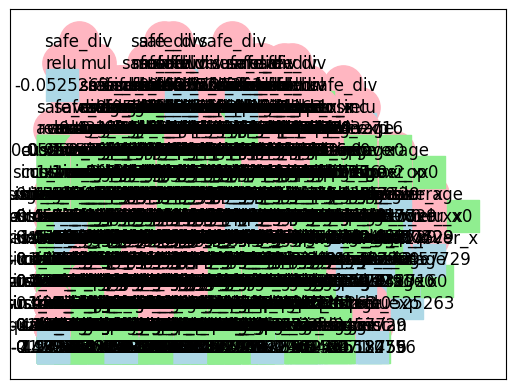

In [13]:
def main():
    """
    Main function to run the genetic programming algorithm.
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    
    print(f"Loading problem {selected_problem}...")
    print(f"Data shape: x={x_data.shape}, y={y_true.shape}")
    
    # Initialize operators and GP system
    print("Initializing GP system...")
    global gp, population
    # Initialize the GP system
    """gp = DagGP(
        operators=operators,
        variables=x_data.shape[1],
        constants=np.linspace(-5, 5, 500)
    )"""
    
    # Initialize population with diverse individuals
    print("Initializing population...")
    population = []
    
    # Initialize with diverse sizes
    for _ in range(POP_SIZE):
        size = np.random.randint(INITIAL_SIZE_MIN, INITIAL_SIZE_MAX + 1)
        ind = gp.create_individual(size)
        ind.fitness = unified_compute_fitness(ind)
        population.append(ind)
    
    # Try to include specialized solutions
    print("Adding specialized solutions to population...")
    valid_solutions = []
    special_solutions = try_create_special_solutions()
    
    for solution in special_solutions:
        try:
            _ = gp.evaluate2(solution, x_data[:1], variable_names=[f'x{i}' for i in range(x_data.shape[1])])
            solution.fitness = unified_compute_fitness(solution)
            valid_solutions.append(solution)
        except Exception as e:
            print(f"Error evaluating solution: {e}")
    
    # Add valid solutions to the population
    for solution in valid_solutions:
        if len(population) >= POP_SIZE:
            lower_half = sorted(population, key=lambda ind: ind.fitness)[:POP_SIZE // 2]
            to_replace = np.random.choice(lower_half)
            population.remove(to_replace)
        population.append(solution)
    
    print(f"Initial population size: {len(population)}")
    
    # Run the evolutionary algorithm
    print("\nStarting evolutionary process...")
    (final_population, best_fitness_history, avg_fitness_history, 
     complexity_history, diversity_history, found_special_solution, 
     special_solution_gen, best_formula_found) = run_streamlined_evolution()    #-------------------------------------------------------------
    
    
    print("\nEvolution completed!")
    
    # Plot fitness evolution and population statistics
    print("Generating plots...")
    plt.figure(figsize=(15, 12))
    
    # Plot fitness evolution
    plt.subplot(3, 1, 1)
    plt.plot(best_fitness_history, label="Best Fitness")
    #plt.plot(avg_fitness_history, label="Average Fitness")
    if found_special_solution:
        plt.axvline(x=special_solution_gen, color='r', linestyle='--', 
                    label=f"{best_formula_found} found (gen {special_solution_gen})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness (negative MSE with penalty)")
    plt.title("Evolution of Fitness")
    plt.legend()
    plt.grid(True)
    
    # Plot complexity
    plt.subplot(3, 1, 2)
    plt.plot(complexity_history, label="Complexity (nodes)")
    plt.xlabel("Generation")
    plt.ylabel("Number of Nodes")
    plt.title("Complexity of Best Individual")
    plt.legend()
    plt.grid(True)
    
    # Plot diversity
    plt.subplot(3, 1, 3)
    plt.plot(diversity_history, label="Population Diversity", color="green")
    plt.xlabel("Generation")
    plt.ylabel("Diversity (semantic distance)")
    plt.title("Population Diversity")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"evolution_problem_{selected_problem}.png")
    plt.show()
    
    # Visualize and Print the Best Individual
    best_individual = final_population[0]
    try:
        best_individual.draw()  # Leverage the teacher library's built-in draw method
        plt.title("Best GP Expression Tree")
        plt.savefig(f"best_tree_problem_{selected_problem}.png")
        plt.show()
    except Exception as e:
        print(f"Tree visualization failed: {e}")
    
    print("\nBest formula:", best_individual.long_name)
    
    # Compare Model Prediction vs Ground Truth
    predicted = gp.evaluate2(best_individual, x_data, 
                            variable_names=[f'x{i}' for i in range(x_data.shape[1])])
    plt.figure(figsize=(12, 6))
    plt.plot(predicted, label="GP Prediction", color="blue")
    plt.plot(y_true, label="True Data", color="red", linestyle="--")
    plt.xlabel("Data Index")
    plt.ylabel("Output")
    plt.title("GP Model Prediction vs Ground Truth")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"prediction_problem_{selected_problem}.png")
    plt.show()
    
    # Calculate MSE to evaluate solution quality
    mse = np.mean((np.array(predicted) - y_true) ** 2)
    print(f"\nMean Squared Error: {mse:.6f}")
    
    # Split data into training and validation sets
    split_index = int(0.8 * len(y_true))
    x_train = x_data[:split_index]
    x_validation = x_data[split_index:]
    y_train = y_true[:split_index]
    y_validation = y_true[split_index:]
    
    def evaluate_best(x):
        return gp.evaluate2(best_individual, x, variable_names=[f'x{i}' for i in range(x.shape[1])])
    
    pred_train = evaluate_best(x_train)
    pred_validation = evaluate_best(x_validation)
    
    # Print MSE using teacher's style
    train_mse = 100 * np.square(np.array(y_train) - np.array(pred_train)).sum() / len(y_train)
    validation_mse = 100 * np.square(np.array(y_validation) - np.array(pred_validation)).sum() / len(y_validation)
    
    print(f"MSE (train): {train_mse:g}")
    print(f"MSE (validation): {validation_mse:g}")
    
    # Save best solution information
    with open(f"solution_problem_{selected_problem}.txt", "w") as f:
        f.write(f"Best formula: {best_individual.long_name}\n")
        f.write(f"MSE (train): {train_mse:g}\n")
        f.write(f"MSE (validation): {validation_mse:g}\n")
        f.write(f"Complexity (nodes): {len(collect_nodes(best_individual))}\n")
        f.write(f"Final fitness: {best_individual.fitness}\n")
        if found_special_solution:
            f.write(f"Found {best_formula_found} at generation {special_solution_gen}\n")
    
    print("\nResults saved to files.")
    return best_individual

if __name__ == "__main__":
    best_solution = main()